Download the data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-10 03:35:40--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.204.93, 13.32.204.49, 13.32.204.34, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.204.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.01s   

2020-11-10 03:35:41 (265 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian

In [2]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Italian.txt', 'data/names/Korean.txt', 'data/names/Czech.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/Vietnamese.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Polish.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt']
Slusarski


In [4]:
print(len(category_lines['Italian'][:]))

709


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [5]:
print(category_lines['Italian'][:5])

["D'onofrio", 'Silvestri', 'Baggi', 'Abbatangelo', 'Colombera']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [7]:
import torch.nn as nn
from torch.autograd import Variable
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)  

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [8]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)
output, next_hidden = rnn.forward(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [9]:

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8795, -2.9115, -2.8724, -2.8815, -2.8311, -2.8175, -2.8389, -2.8910,
         -2.8489, -2.9061, -2.9639, -2.8874, -2.8779, -2.9310, -2.9051, -2.9023,
         -2.9834, -2.9126]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 5)


We will also want a quick way to get a training example (a name and its
language):




In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Kaibara
category = Dutch / line = Maes
category = Czech / line = Veverka
category = Spanish / line = Blanco
category = Czech / line = Kauphsman
category = Korean / line = Kwang 
category = Czech / line = Divoky
category = French / line = Baudin
category = Polish / line = Zawisza
category = Greek / line = Brisimitzakis


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [12]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [13]:
optimizer = torch.optim.Adam(rnn.parameters())

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    # cState = rnn.initHidden()

    # reset gradient
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
          output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [14]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses_1 = []
all_validation_losses_1 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

def eval_dataset(dataset):
    loss = 0
    n_instances = 0
    confusion1 = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion1[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion1[i] = confusion1[i] / confusion1[i].sum()

    return loss.item() / n_instances, confusion1
  
print('\n1Iter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_1.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_1) == 0 or average_validation_loss < min(all_validation_losses_1):
            torch.save(rnn, 'char_rnn_classification_model.pt')
        all_validation_losses_1.append(average_validation_loss)


1Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 17s) 	1.9263 		Pae / Chinese ✗ (Korean)
10000 	12% 	(0m 36s) 	1.6053 		Confortola / Spanish ✗ (Italian)
15000 	18% 	(0m 56s) 	1.4312 		Viola / Spanish ✗ (Italian)
20000 	25% 	(1m 15s) 	1.3499 		Gardinier / German ✗ (French)
25000 	31% 	(1m 34s) 	1.3606 		Arian / Irish ✗ (Arabic)
30000 	37% 	(1m 53s) 	1.2971 		Frankish / Russian ✗ (English)
35000 	43% 	(2m 12s) 	1.2787 		Bertsimas / Greek ✓
40000 	50% 	(2m 32s) 	1.3304 		Kieu / Vietnamese ✓
45000 	56% 	(2m 52s) 	1.2827 		Jurkovsky / Russian ✓
50000 	62% 	(3m 12s) 	1.2050 		Zhurbenko / Russian ✓
55000 	68% 	(3m 32s) 	1.1370 		Iskin / Russian ✓
60000 	75% 	(3m 51s) 	1.1338 		Nelissen / Dutch ✓
65000 	81% 	(4m 11s) 	1.2427 		Kumasaka / Japanese ✓
70000 	87% 	(4m 31s) 	1.2252 		Huraskin / Russian ✓
75000 	93% 	(4m 52s) 	1.1523 		Dasios / Portuguese ✗ (Greek)
80000 	100% 	(5m 13s) 	1.0928 		Docherty / English ✗ (Scottish)


# Creating the Network with GRU:



In [15]:
  class RNNGRU(nn.Module):
      def __init__(self, input_size, hidden_size, output_size):
          super(RNNGRU, self).__init__()

          self.hidden_size = hidden_size

          self.i2h = nn.GRUCell(input_size, hidden_size)
          self.h2o = nn.Linear(hidden_size, output_size)
          self.softmax = nn.LogSoftmax(dim=1)

      def forward(self, input, hidden):
          hidden = self.i2h(input, hidden) 
          output = self.h2o(hidden)
          output = self.softmax(output)
          return output, hidden

      def initHidden(self):
          return torch.zeros(1, self.hidden_size)
  n_hidden = 128
  rnn = RNNGRU(n_letters, n_hidden, n_categories)   

In [16]:
optimizer = torch.optim.Adam(rnn.parameters())

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # reset gradient
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden) 
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

# GRU training

In [17]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses_2 = []
all_validation_losses_2 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden) 
    return output

def eval_dataset(dataset):
    loss = 0
    n_instances = 0
    confusion2 = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion2[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion2[i] = confusion2[i] / confusion2[i].sum()

    return loss.item() / n_instances, confusion2
  
print('\n2Iter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_2.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_2) == 0 or average_validation_loss < min(all_validation_losses_2):
            torch.save(rnn, 'char_rnn_classification_model2.pt')
        all_validation_losses_2.append(average_validation_loss)




2Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 36s) 	1.4569 		Fleming / German ✗ (Scottish)
10000 	12% 	(1m 16s) 	1.1807 		Van / Vietnamese ✓
15000 	18% 	(1m 57s) 	0.9677 		Bradshaw / English ✓
20000 	25% 	(2m 38s) 	0.7536 		Raikatuji / Japanese ✓
25000 	31% 	(3m 18s) 	0.6562 		Tsigelnik / Russian ✓
30000 	37% 	(3m 59s) 	0.5126 		Cline / French ✗ (German)
35000 	43% 	(4m 39s) 	0.4638 		Hoult / German ✗ (English)
40000 	50% 	(5m 19s) 	0.3773 		Jones / Scottish ✓
45000 	56% 	(5m 59s) 	0.3068 		Leitner / German ✓
50000 	62% 	(6m 39s) 	0.3503 		Shiomiya / Japanese ✓
55000 	68% 	(7m 18s) 	0.3026 		Guerra / Spanish ✗ (Portuguese)
60000 	75% 	(7m 56s) 	0.3128 		Diep / Vietnamese ✓
65000 	81% 	(8m 35s) 	0.2733 		Samson / Dutch ✗ (French)
70000 	87% 	(9m 14s) 	0.2499 		Gouveia / Portuguese ✓
75000 	93% 	(9m 53s) 	0.2359 		Kim / Vietnamese ✓
80000 	100% 	(10m 33s) 	0.2489 		Tsujimura / Japanese ✓


# Creating the Network with LSTM:

In [18]:
  class RNNLSTM(nn.Module):
      def __init__(self, input_size, hidden_size, output_size):
          super(RNNLSTM, self).__init__()

          self.hidden_size = hidden_size

          self.i2h = nn.LSTMCell(input_size, hidden_size)
          self.h2o = nn.Linear(hidden_size, output_size)
          self.softmax = nn.LogSoftmax(dim=1)

      def forward(self, input, hidden, cstate):
          hidden, cstate = self.i2h(input,(hidden, cstate))
          output = self.h2o(hidden)
          output = self.softmax(output)
          return output, hidden, cstate

      def initHidden(self):
          return torch.zeros(1, self.hidden_size)
  n_hidden = 128
  rnn = RNNLSTM(n_letters, n_hidden, n_categories)

In [19]:
optimizer = torch.optim.Adam(rnn.parameters())

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    cState = rnn.initHidden()

    # reset gradient
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]): 
           output, hidden, cState = rnn(line_tensor[i], hidden, cState)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

# LSTM training:

In [20]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses_3 = []
all_validation_losses_3 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate3(line_tensor):
    hidden = rnn.initHidden()
    cState = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden, cState = rnn(line_tensor[i], hidden, cState)
    return output

def eval_dataset3(dataset):
    loss = 0
    n_instances = 0
    confusion3 = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate3(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion3[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion3[i] = confusion3[i] / confusion3[i].sum()

    return loss.item() / n_instances, confusion3
  
print('\n3Iter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_3.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss3, _ = eval_dataset3(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_3) == 0 or average_validation_loss3 < min(all_validation_losses_3):
            torch.save(rnn, 'char_rnn_classification_model3.pt')
        all_validation_losses_3.append(average_validation_loss3)



3Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 35s) 	1.5575 		Sui / Chinese ✓
10000 	12% 	(1m 15s) 	1.2413 		Duarte / French ✗ (Portuguese)
15000 	18% 	(1m 55s) 	1.0509 		Garver / Portuguese ✗ (German)
20000 	25% 	(2m 36s) 	0.8305 		Guadarrama / Portuguese ✗ (Spanish)
25000 	31% 	(3m 16s) 	0.6380 		Aggelen / Dutch ✓
30000 	37% 	(3m 56s) 	0.5578 		Derrick / Czech ✗ (German)
35000 	43% 	(4m 37s) 	0.5175 		Le / Vietnamese ✓
40000 	50% 	(5m 17s) 	0.4196 		Delgado / Spanish ✗ (Portuguese)
45000 	56% 	(5m 57s) 	0.4075 		Hwang / Korean ✓
50000 	62% 	(6m 38s) 	0.3621 		Mcgregor / Scottish ✓
55000 	68% 	(7m 18s) 	0.3766 		Perina / Italian ✗ (Czech)
60000 	75% 	(7m 58s) 	0.3242 		Meeuwe / Dutch ✓
65000 	81% 	(8m 38s) 	0.2918 		Niall / Irish ✓
70000 	87% 	(9m 18s) 	0.3041 		Esan / Japanese ✗ (English)
75000 	93% 	(9m 58s) 	0.2423 		Ogterop / Dutch ✓
80000 	100% 	(10m 38s) 	0.2277 		Nacar / Czech ✗ (Italian)


# Evaluating the Results


Average test loss_Linear: 1.3064941080837638


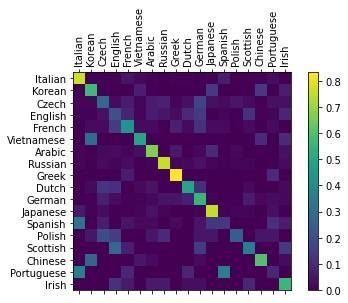

Average test loss_GRU: 0.948005205946976


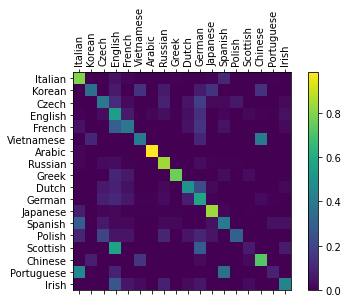

Average test loss_LSTM: 0.941829204718219


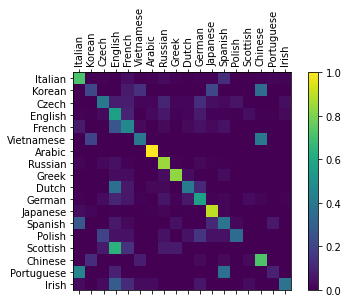

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# evaluate on test set and display confusion matrix1
rnn = torch.load('char_rnn_classification_model.pt')
average_test_loss1, confusion1 = eval_dataset(test_data)
print('Average test loss_Linear: ' + str(average_test_loss1))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion1.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


# evaluate on test set and display confusion matrix2
rnn = torch.load('char_rnn_classification_model2.pt')
average_test_loss2, confusion2 = eval_dataset(test_data)
print('Average test loss_GRU: ' + str(average_test_loss2))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion2.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


# evaluate on test set and display confusion matrix3
rnn = torch.load('char_rnn_classification_model3.pt')
average_test_loss3, confusion3 = eval_dataset3(test_data)
print('Average test loss_LSTM: ' + str(average_test_loss3))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion3.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




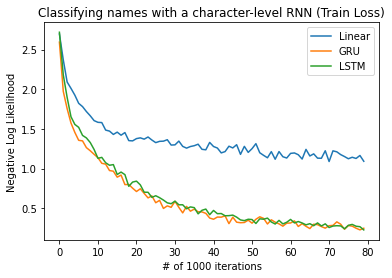

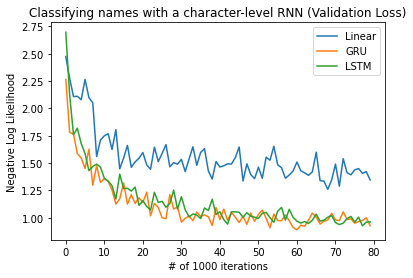

In [22]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
 
plt.figure()
plt.plot(all_train_losses_1)
plt.plot(all_train_losses_2)
plt.plot(all_train_losses_3)
plt.title('Classifying names with a character-level RNN (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear','GRU','LSTM'], loc='upper right')


plt.figure()
plt.plot(all_validation_losses_1)
plt.plot(all_validation_losses_2)
plt.plot(all_validation_losses_3)
plt.title('Classifying names with a character-level RNN (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear','GRU','LSTM'], loc='upper right')


# **Discussion**

In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

The following paper titled Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling https://arxiv.org/pdf/1412.3555v1.pdf provides a thorough analysis between the difference in two. They also conclude that — “we could not make concrete conclusion on which of the two gating units was better.” In many tasks both architectures yield comparable performance and tuning hyperparameters like layer size is probably more important than picking the ideal architecture. This can clearly be seen in my results as well. The performance of LSTM and GRU are really close that the difference could be ignored.

Considering small differences:
In this assignment as we can see as we move from Vanilla RNN to GRU and then LSTM we get a lower average loss. when we move from RNN to LSTM, we are introducing more & more controlling variables, which control the flow and mixing of Inputs as per trained Weights. And thus, bringing in more flexibility in controlling the outputs.
So in some cases with large data, LSTM gives us the most Controlability and thus, Better Results. But also comes with more Complexity and Operating Cost. 